In [1]:
%matplotlib inline

import random
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [2]:
def plot_degree_dist(G, lobf=None):
    
    G_degrees = np.array(nx.degree(G, weight="weight").values())
    a = np.arange(1, G_degrees.max() + 1)
    b = np.array([(G_degrees==i).sum() for i in a], dtype=np.float)
    idx = np.where(b > 0)[0]
    a = a[idx]
    b = b[idx]
    
    b = b / b.sum()
    
    log_a = np.log10(a)
    log_b = np.log10(b)
    
    coefficients = np.polyfit(log_a, log_b, 1,)
    print coefficients
#     polynomial = np.poly1d(coefficients)
    ys = 10 ** coefficients[1] * a ** coefficients[0]
    
    fig = plt.figure()
    ax = plt.gca()
    ax.scatter(a, b, )
    ax.plot(a, ys, c="k")
    if lobf is not None:
        ax.plot(lobf[0], lobf[1], c="r")
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel("k")
    ax.set_ylabel("p(k)")
    ax.set_xlim([1e0, 1e3])
    ax.set_ylim([1e-4, 1e-0])
#     ax.plot(log_a, log_b)
    return a, ys


def draw_network(G):
    plt.figure(figsize=(10,10))
    pos = nx.fruchterman_reingold_layout(G)
    nx.draw_networkx_nodes(G, pos,)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos=pos)

In [229]:
def contracted_nodes(G, nodes, self_loops=False):
    
    for u, v in nodes:
        if G.is_directed():
            in_edges = ((w, u, d) for w, x, d in G.in_edges(v, data=True)
                        if self_loops or w != u)
            out_edges = ((u, w, d) for x, w, d in G.out_edges(v, data=True)
                         if self_loops or w != u)
            new_edges = chain(in_edges, out_edges)
        else:
            new_edges = ((u, w, d) for x, w, d in G.edges(v, data=True)
                         if self_loops or w != u)
        v_data = G.node[v]
        G.remove_node(v)
#         G.add_edges_from(new_edges)
        if 'contraction' in G.node[u]:
            G.node[u]['contraction'][v] = v_data
        else:
            G.node[u]['contraction'] = {v: v_data}
            
# def select_nodes_edge_collapse(G, thres=0.9):
    
#     degrees = nx.degree(G)
    
#     nodes = []
#     covered_nodes = []
#     for u in G.nodes():
#         if u in covered_nodes:
#             continue
#         for v in G.neighbors(u):
#             if v in covered_nodes:
#                 continue
#             nodes.append((v, u))
#             covered_nodes.extend([u,v])
#             break
                
#     return nodes

def perimeter_nodes(G, use_idx=False):
    if use_idx:
        degrees = {i : G.degree(n) for i, n in enumerate(G.nodes())}
        A = nx.adjacency_matrix(G).toarray()
    else:
        degrees = nx.degree(G)
    for u in sorted(degrees, key=degrees.get):
        flag = True
        if use_idx:
            neighbours = np.where(A[u] > 0)[0]
        else:
            neighbours = G.neighbors(u)
        for v in neighbours:
            if degrees[v] < degrees[u]:
                flag = False
                break
        if flag:
            yield u

def select_nodes_edge_collapse(G, thres=0.9):
    
    N = nx.number_of_nodes(G)
    A = nx.adjacency_matrix(G)
    S = cosine_similarity(A) - np.identity(N)
    
#     degrees = nx.degree(G)
    degrees = {i : nx.degree(G, n) for i, n in enumerate(G.nodes())}
#     nodes_sorted_by_degree = sorted(degrees, key=degrees.get)
#     min_degree = min(degrees.values())
#     nodes_with_min_degree = (k for k, v in degrees.items() if v == min_degree)
    nodes = []
    covered_nodes = []
    num_perimeter_nodes = 0
    for u in perimeter_nodes(G, use_idx=True):
        num_perimeter_nodes += 1
        if u in covered_nodes:
            continue
#         neighbour_degrees = G.degree(G.neighbors(u))
#         for v in sorted(neighbour_degrees, key=neighbour_degrees.get):
#             if v in covered_nodes:
#                 continue
        for v in S[u].argsort()[::-1]:
            if degrees[v] > degrees[u]:
                nodes.append((G.nodes()[v], G.nodes()[u]))
                covered_nodes.extend([u, v])
                break
                
    print "number of perimeter nodes={}".format(num_perimeter_nodes)
    return nodes

def select_nodes_star_collapse(G, thres=0.9):
    
    N = nx.number_of_nodes(G)
    A = nx.adjacency_matrix(G)
    S = cosine_similarity(A) - np.identity(N)

    degrees = {i : nx.degree(G, n) for i, n in enumerate(G.nodes())}
    nodes_sorted_by_degree = sorted(degrees, key=degrees.get)
    min_degree = min(degrees.values())
    nodes_with_min_degree = (k for k, v in degrees.items() if v == min_degree)
    
    nodes = []
    covered_nodes = []
#     for u in range(N):
    for u in nodes_sorted_by_degree[::-1]:
#     for u in perimeter_nodes(G, use_idx=True):
#     for u in nodes_with_min_degree:
        if u in covered_nodes:
            continue
            
        for v in S[u].argsort()[::-1]:
            if S[u, v] < thres:
                break
#             if degrees[v] <= degrees[u]:
#                 continue
            if v in covered_nodes:
                continue
#             print S[u,v]
            nodes.append((G.nodes()[v], G.nodes()[u]))
            covered_nodes.extend([u, v])
            break
            
    return nodes

def edge_collapse(G, thres):
    nodes = select_nodes_edge_collapse(G, thres)
    contracted_nodes(G, nodes)

def star_collapse(G, thres):
    nodes = select_nodes_star_collapse(G, thres)
    contracted_nodes(G, nodes)
    
def remove_unsimilar_edges(G, thres):
    
    
    N = nx.number_of_nodes(G)
    A = nx.adjacency_matrix(G).todense()
    S = cosine_similarity(A)
    
    covered_nodes = []
    edges_to_remove = []
    
    for u in range(N):
        if u in covered_nodes:
            continue
        edges = np.where(A[u] > 0)[1]
        if len(edges) <= 1:
            continue
        idx = S[u, edges].argsort()
        v = edges[idx[0]]
        if v in covered_nodes:
            continue
        edges_to_remove.append((G.nodes()[u], G.nodes()[v]))
        covered_nodes.extend([u, v])
        
    G.remove_edges_from(edges_to_remove)

def random_vertex_sampling(G, p=0.5):
    N = nx.number_of_nodes(G)
    r = np.random.rand(N)
    nodes = np.array(G.nodes())
    return G.subgraph(nodes[r > p])

def random_walk_sampling(G, p=0.15):
    
    N = nx.number_of_nodes(G)
    A = np.array(nx.adjacency_matrix(G).todense(), dtype=np.float)
    A /= A.sum(axis=0)
    
    degrees = np.array(nx.degree(G).values(), dtype=np.float)
    degrees /= degrees.sum()
    
    flag = False
    
    while not flag:
    
        print "restarting"
        nodes = []
        edges = []
        starting_node = np.random.choice(N, p=degrees)
        current_node = starting_node
        i = 0

        while len(nodes) < N / 2:

            if i >= 100 * N:
                break

            if np.random.rand() < p:
                current_node = starting_node
            else:
                new_node = np.random.choice(N, p=A[:,current_node])
                edges.append((G.nodes()[current_node], G.nodes()[new_node]))
                current_node = new_node

            if current_node not in nodes:
                nodes.append(current_node)

            i += 1
        
        if len(nodes) == N / 2:
            flag = True
    
#     return G.subgraph([G.nodes()[n] for n in nodes])
    return nx.Graph(edges)

In [240]:
G = nx.read_gml("../data/facebook_graph.gml")
G = max(nx.connected_component_subgraphs(G), key=len)

In [219]:
G = nx.Graph(nx.scale_free_graph(1000).to_undirected())

In [95]:
# plot_degree_dist(G)

4039 88234

[-1.18016442 -0.43091761]
number of perimeter nodes=888
0 3337 82418
change=702
True 1
[-1.02105291 -0.68133559]

number of perimeter nodes=458
1 2963 78854
change=374
True 1
[-0.91528065 -0.86501083]

number of perimeter nodes=297
2 2706 76159
change=257
False 2
[-0.95135955 -0.75546768]

number of perimeter nodes=229
3 2489 73648
change=217
False 2
[-0.86183412 -0.91176498]

number of perimeter nodes=171
4 2328 71626
change=161
False 2
[-0.74123466 -1.13061489]



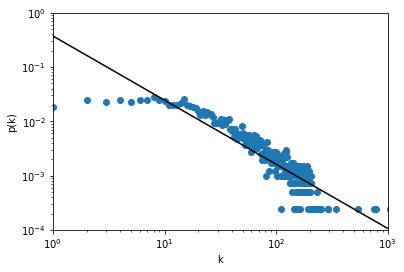

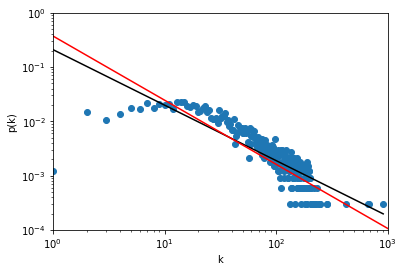

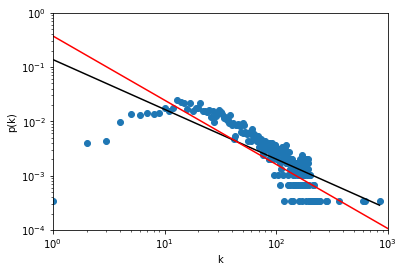

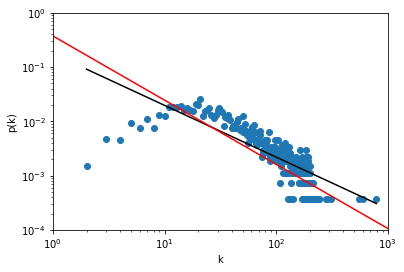

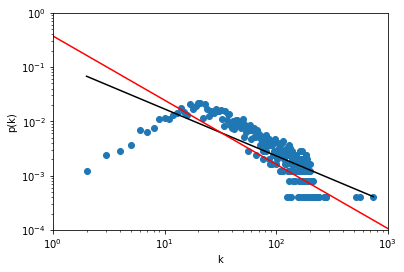

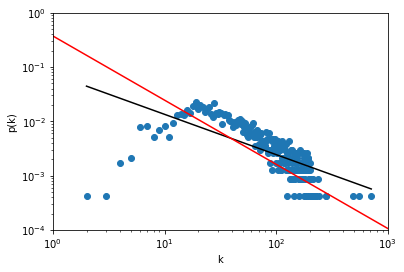

In [241]:
H = G.copy()
print nx.number_of_nodes(H), nx.number_of_edges(H)
print 

lobf = plot_degree_dist(H)

i = 0
num_nodes = nx.number_of_nodes(H)
change = np.inf
while change > 0 and len(H) > 100 and i < 5:
    
#     H = random_walk_sampling(H, p=0.15)
#     star_collapse(H, thres=1.0)
#     print i, nx.number_of_nodes(H), nx.number_of_edges(H)
    edge_collapse(H, thres=0.01)
    print i, nx.number_of_nodes(H), nx.number_of_edges(H)
#     remove_unsimilar_edges(H, thres=0.5)
#     print i, nx.number_of_nodes(H), nx.number_of_edges(H)
    nx.write_edgelist(H, "../data/collapsed_{}.edg".format(i), delimiter="\t", )
    change = num_nodes - nx.number_of_nodes(H)
    print "change={}".format(change)
    print nx.is_connected(H), nx.number_connected_components(H)
    num_nodes = nx.number_of_nodes(H)
#     draw_network(H)
    plot_degree_dist(H, lobf)
    i = i + 1
    print

In [242]:
H.nodes(data=True)

[(1,
  {'contraction': {130: {'contraction': {1238: {'id': 1238, 'label': u'3795'}},
     'id': 130,
     'label': u'3512'}},
   'id': 1,
   'label': u'3734'}),
 (7, {'id': 7, 'label': u'4023'}),
 (11, {'id': 11, 'label': u'643'}),
 (14, {'id': 14, 'label': u'592'}),
 (15, {'id': 15, 'label': u'2030'}),
 (17,
  {'contraction': {918: {'id': 918, 'label': u'221'}},
   'id': 17,
   'label': u'345'}),
 (18, {'id': 18, 'label': u'346'}),
 (22, {'id': 22, 'label': u'342'}),
 (23, {'id': 23, 'label': u'343'}),
 (24,
  {'contraction': {3375: {'id': 3375, 'label': u'3156'},
    3926: {'id': 3926, 'label': u'2816'}},
   'id': 24,
   'label': u'2918'}),
 (28, {'id': 28, 'label': u'348'}),
 (32, {'id': 32, 'label': u'3002'}),
 (34,
  {'contraction': {2724: {'id': 2724, 'label': u'2746'}},
   'id': 34,
   'label': u'2919'}),
 (36, {'id': 36, 'label': u'2318'}),
 (37, {'id': 37, 'label': u'2319'}),
 (39,
  {'contraction': {38: {'id': 38, 'label': u'2316'}},
   'id': 39,
   'label': u'2317'}),
 (40,


In [237]:
!rm ../data/collapsed_*